In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-vs-human-text/AI_Human.csv


In [3]:
df = pd.read_csv('/kaggle/input/ai-vs-human-text/AI_Human.csv')

In [4]:
# Count total entries
total_entries = len(df['generated'])

# Count AI-generated text
ai_generated_count = df['generated'].eq(1.0).sum()

# Count human-generated text
human_generated_count = df['generated'].eq(0.0).sum()

# Print the results
print("Total :", total_entries)
print("Total text by AI :", ai_generated_count)
print("Total text by Human :", human_generated_count)

Total : 487235
Total text by AI : 181438
Total text by Human : 305797


<Axes: xlabel='generated', ylabel='count'>

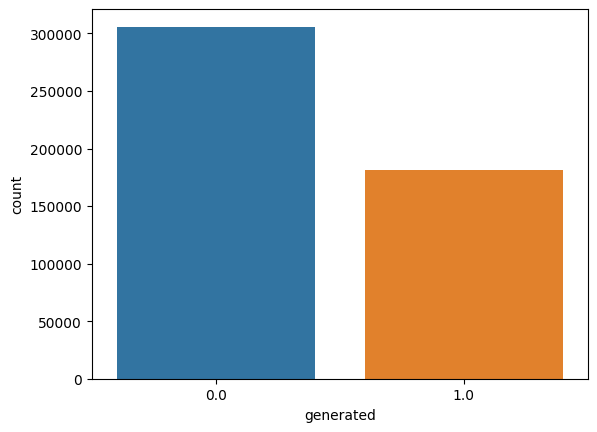

In [5]:
import seaborn as sns
sns.countplot(data=df,x='generated')

In [6]:
import pandas as pd


desired_count = 10000

ai_generated_count = df['generated'].eq(1.0).sum()
human_generated_count = df['generated'].eq(0.0).sum()

min_available = min(ai_generated_count, human_generated_count)
final_count = min(desired_count, min_available)

df_ai = df[df['generated'] == 1.0].sample(final_count, random_state=42)
df_human = df[df['generated'] == 0.0].sample(final_count, random_state=42)

df_balanced = pd.concat([df_ai, df_human])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Total data points after balancing: {len(df_balanced)}")
print(f"AI-generated text: {df_balanced['generated'].eq(1.0).sum()}")
print(f"Human-generated text: {df_balanced['generated'].eq(0.0).sum()}")


Total data points after balancing: 20000
AI-generated text: 10000
Human-generated text: 10000


<Axes: xlabel='generated', ylabel='count'>

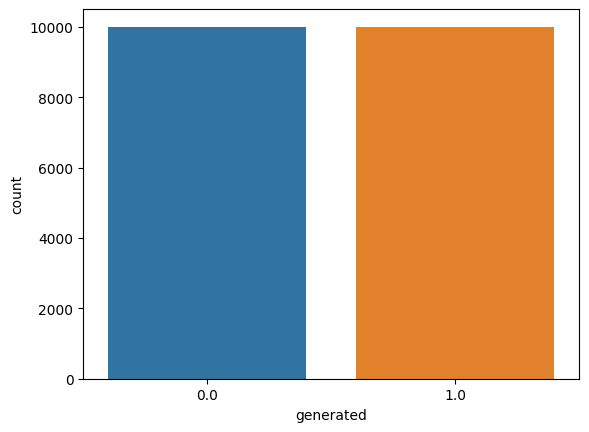

In [7]:
import seaborn as sns
sns.countplot(data=df_balanced,x='generated')

# **Preprocessing**

In [8]:
df_balanced['text'][0]

'Some people think that aliens created the Face on Mars. Do you believe that to? I think that The Face on Mars is a natural landform here is why. " The caption wrote huge rock formation" which would post likely mean a natural landform from what N.A.S.A. stated when they unveiled the photo of the rock formation. Also has not found any evidence of life on Mars to this day.\n\nN.A.S.A. had also said "That if there were objects in this picture like airplanes, on the ground or Egyptian style pyramids or even small shacks, you could see what they were." Also in the pictures that are in the article the rare no signs of any hopes or camps or signs of life.\n\nThis also proves the theory that it is a landform "what the picture actually shows is the Martian equivalent of a butte or pesalandforps coupon around the American West which would mean that this is soothing similar to what we have seen on earth before. The Jet Propulsion Lab said" Scientist figured it was just another Martian ESA.\n\nAls

# **tags Removal**

In [9]:
def remove_tags(text):
    tags = ['\n', '\'']
    for tag in tags:
        text = text.replace(tag, '')
    
    return text


df_balanced['text'] = df_balanced['text'].apply(remove_tags)

In [10]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [11]:
def remove_punc(text):
    new_text = [x for x in text if x not in string.punctuation]
    new_text = ''.join(new_text)
    return new_text

df_balanced['text']=df_balanced['text'].apply(remove_punc)

# **Spell Check**

In [12]:
import nltk
from nltk.corpus import words

nltk.download('words')
english_words = set(words.words())


def is_spelled_correctly(word):
    return word in english_words

[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [13]:
word_to_check = df_balanced['text'][12000]
if is_spelled_correctly(word_to_check):
    print(f"The word '{word_to_check}' is spelled correctly.")
else:
    print(f"The word '{word_to_check}' is spelled incorrectly.")

The word 'Cell phone use in the classroom has been a Widely debated topic in recent years With many schools implementing rules and regulations to govern their use My opinion is that cell phones should be alloyed in the classroom as long as they are used responsibly and With the proper guidelines in placeCell phones can be a great Yay to access resources both inside and outside the classroom Students can use their phones to look up relevant information that can be used in class discussions They can also take pictures or videos of their notes Which alloys them to study more effectively at home or While on break Additionally phones can serve as a tool to stay organized reminders todo lists and alarms can help students keep on track and stay on taskFurthermore alloying cell phone usage can help foster relationships between students and teachers By having access to their phones students can contact their teachers With questions or for further help This Would lead to more meaningful collabor

# **Stop Words Removal**

In [14]:
from nltk.corpus import stopwords
nltk.download('stopwords')

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filtered_words= ' '.join(filtered_words)
    return filtered_words

df_balanced['text']=df_balanced['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
df_balanced['text'][0]

'people think aliens created Face Mars believe think Face Mars natural landform caption wrote huge rock formation would post likely mean natural landform NASA stated unveiled photo rock formation Also found evidence life Mars dayNASA also said objects picture like airplanes ground Egyptian style pyramids even small shacks could see Also pictures article rare signs hopes camps signs lifeThis also proves theory landform picture actually shows Martian equivalent butte pesalandforps coupon around American West would mean soothing similar seen earth Jet Propulsion Lab said Scientist figured another Martian ESAAlso something created aliens ancient civilization wouldnt deteriorating TIPE reach NASA done seeps changed past 25 years believe aliens created Face Mars dont pa bye'

# **Model**

In [15]:
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForPreTraining, AutoTokenizer
from transformers import AutoTokenizer, RobertaModel
from transformers import RobertaTokenizer
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

2025-04-27 02:53:53.183034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745722433.403132      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745722433.465478      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

In [17]:
tokenizer = tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [18]:
import warnings
# Ignore FutureWarnings from the tokenization_utils_base module
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.tokenization_utils_base")

In [19]:
sample_txt = 'Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday.'

In [20]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday.
   Tokens: ['Trump', 'campaign', 'ad', '##viser', 'George', 'Papa', '##do', '##pou', '##los', 'told', 'an', 'Australian', 'diplomat', 'in', 'May', '2016', 'that', 'Russia', 'had', 'political', 'dir', '##t', 'on', 'Democratic', 'presidential', 'candidate', 'Hillary', 'Clinton', ',', 'the', 'New', 'York', 'Times', 'reported', 'on', 'Saturday', '.']
Token IDs: [29846, 17323, 10840, 54478, 10955, 17429, 10317, 73535, 13788, 21937, 10151, 12829, 45652, 10106, 10725, 10255, 10189, 14664, 10374, 13736, 15895, 10123, 10135, 19281, 36476, 22102, 72734, 24139, 117, 10105, 10287, 10482, 12020, 15943, 10135, 24848, 119]


In [21]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',  # Return PyTorch tensors

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

# **Tokenisation**

In [22]:
token_lens = []

for txt in df_balanced.text:
  #tokenizing the text
      tokens = tokenizer.encode(txt, max_length=512,truncation=True)
      token_lens.append(len(tokens))

In [56]:
df_balanced['text'][2]

'Race Mars Really Natural LandformMany people see iconic landform photographed Viking spacecraft Mars 1976 believe must ie artificial structure created intelligent lifeforms However upon closer examination evidence becomes clear Race Mars simply naturally formed mesa hill One main pieces evidence landform natural comes higher resolution images taken later Mars missions images reveal supposed eyes mouth face merely valleys shadows caused erosion geological timescales fine detail needed clearly define facial features present Instead see uneven forms vaguely resemble human face viewed distant low resolution image addition scientists understand wind erosion carves interesting shapes red planets landscapes Mars thin atmosphere allows solar wind particles slowly arcade away exposed rock dirt millions years sculpting action form mesas buttes elevated features appear strange angles shapes often resemble familiar patterns eyes due parabolic However closer examination reveals forged natural proc

In [23]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [24]:
import matplotlib.pyplot as plt

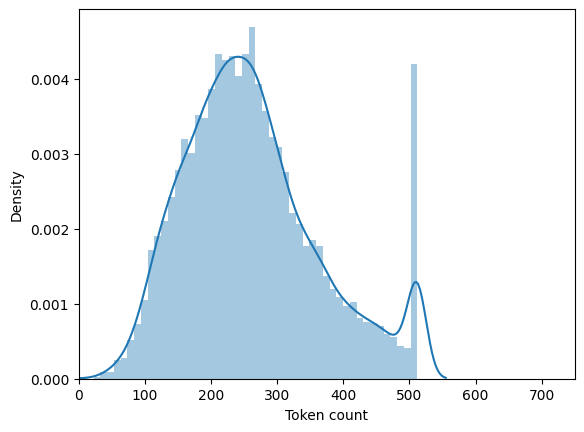

In [25]:
sns.distplot(token_lens)
plt.xlim([0, 750]);
plt.xlabel('Token count');

In [26]:
MAX_LEN = 512

In [27]:
from torch.utils.data import Dataset

In [28]:
class Ai_vs_Human_dataset(Dataset):

  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.text)
  def __getitem__(self, item):
    text = str(self.text[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
df_train, df_test = train_test_split(df_balanced, test_size=0.30, shuffle=True)
df_val, df_test = train_test_split(df_test, test_size=0.50,shuffle=True)

In [61]:
def create_data_loader(df_balanced, tokenizer, max_len, batch_size):
  ds = Ai_vs_Human_dataset(
    text=df_balanced.text.to_numpy(),
    targets=df_balanced.generated.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )

In [62]:
import warnings

# Ignore the specific FutureWarning related to truncation
warnings.filterwarnings("ignore", message="Truncation was not explicitly activated*")

In [63]:
from torch.utils.data import DataLoader

In [64]:
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [65]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [66]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [67]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([8, 512])
torch.Size([8, 512])
torch.Size([8])


In [68]:
warnings.filterwarnings("ignore")

In [69]:
from transformers import RobertaModel, RobertaTokenizer

PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'
bert_model = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [70]:
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [71]:
last_hidden_state

BertForPreTrainingOutput(loss=None, prediction_logits=tensor([[[-11.1045, -10.9274, -11.1294,  ..., -11.1580, -10.4450, -10.8798],
         [-12.6464, -12.1728, -12.8091,  ..., -13.3262,  -9.5630, -11.9947],
         [-12.7024, -12.7111, -13.1337,  ..., -14.0642, -10.7981, -11.4612],
         ...,
         [-11.4355, -11.2431, -11.0939,  ..., -10.4247,  -9.7767,  -9.9364],
         [-12.7983, -12.7891, -13.1130,  ..., -11.0403, -10.5870, -11.6441],
         [-11.5741, -11.2672, -11.4202,  ...,  -9.9949,  -9.4003, -10.2871]]],
       grad_fn=<ViewBackward0>), seq_relationship_logits=tensor([[ 0.3568, -2.5426]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [72]:
import torch.nn as nn

In [73]:
class Ai_Human_textClassifier(nn.Module):

  def __init__(self, n_classes):
    super(Ai_Human_textClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) #model
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
         input_ids=input_ids,
         attention_mask=attention_mask,
         return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [74]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Définir le device (GPU ou CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [75]:
model = Ai_Human_textClassifier(2)
model = model.to(device)

In [76]:
bert_model.config.hidden_size

768

In [77]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([8, 512])
torch.Size([8, 512])


In [78]:
import torch.nn.functional as F

In [79]:
F.softmax(model(input_ids, attention_mask), dim=1) 

tensor([[0.5852, 0.4148],
        [0.6318, 0.3682],
        [0.6115, 0.3885],
        [0.5776, 0.4224],
        [0.4963, 0.5037],
        [0.5563, 0.4437],
        [0.6021, 0.3979],
        [0.6394, 0.3606]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [80]:
from transformers import get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.optim import AdamW


EPOCHS = 10

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Calcul du nombre de steps
total_steps = len(train_data_loader) * EPOCHS

# Scheduler avec warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=4,
    num_training_steps=total_steps
)

# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)


In [81]:
from tqdm import tqdm
import torch.nn as nn
import numpy as np

def train_epoch(
    model,
    data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    # tqdm for progress monitoring
    data_loader = tqdm(data_loader, desc="Training", unit="batch")

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        # Update tqdm description with the current loss
        data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)


In [82]:
from tqdm import tqdm
import torch
import numpy as np

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    
    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training

In [83]:
import time
from collections import defaultdict
import shutil
import torch

start_time = time.time()

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Sauvegarder et déplacer le modèle si la performance sur validation est améliorée
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        shutil.move('best_model_state.bin', '/kaggle/working/best_model_state.bin')  # Déplacer vers /kaggle/working/
        best_accuracy = val_acc

end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")


Epoch 1/10
----------


Training: 100%|██████████| 1750/1750 [17:12<00:00,  1.69batch/s, loss=0.199]


Train loss 0.19926718425090492 accuracy 0.9373571428571429


Evaluating: 100%|██████████| 375/375 [00:45<00:00,  8.27batch/s, loss=0.0923]


Val   loss 0.09231055756192655 accuracy 0.9813333333333333

Epoch 2/10
----------


Training: 100%|██████████| 1750/1750 [17:14<00:00,  1.69batch/s, loss=0.0625]


Train loss 0.06251034644485169 accuracy 0.9874285714285715


Evaluating: 100%|██████████| 375/375 [00:45<00:00,  8.27batch/s, loss=0.0692]


Val   loss 0.06921133540163282 accuracy 0.987

Epoch 3/10
----------


Training: 100%|██████████| 1750/1750 [17:14<00:00,  1.69batch/s, loss=0.0318]


Train loss 0.031809077077902786 accuracy 0.9945714285714287


Evaluating: 100%|██████████| 375/375 [00:45<00:00,  8.26batch/s, loss=0.247] 


Val   loss 0.24719443786062767 accuracy 0.965

Epoch 4/10
----------


Training: 100%|██████████| 1750/1750 [17:14<00:00,  1.69batch/s, loss=0.0233]


Train loss 0.023326605338237383 accuracy 0.9960714285714286


Evaluating: 100%|██████████| 375/375 [00:45<00:00,  8.25batch/s, loss=0.0457]


Val   loss 0.0456819523331651 accuracy 0.9933333333333333

Epoch 5/10
----------


Training: 100%|██████████| 1750/1750 [17:15<00:00,  1.69batch/s, loss=0.0141]


Train loss 0.014087389001458568 accuracy 0.9975


Evaluating: 100%|██████████| 375/375 [00:45<00:00,  8.19batch/s, loss=0.0755] 


Val   loss 0.07554197731339567 accuracy 0.9913333333333333

Epoch 6/10
----------


Training: 100%|██████████| 1750/1750 [17:15<00:00,  1.69batch/s, loss=0.00802]


Train loss 0.008022290570102217 accuracy 0.9990000000000001


Evaluating: 100%|██████████| 375/375 [00:45<00:00,  8.19batch/s, loss=0.06]  


Val   loss 0.06001398671353915 accuracy 0.9906666666666666

Epoch 7/10
----------


Training: 100%|██████████| 1750/1750 [17:15<00:00,  1.69batch/s, loss=0.0125]


Train loss 0.0124817549925179 accuracy 0.9975714285714287


Evaluating: 100%|██████████| 375/375 [00:45<00:00,  8.22batch/s, loss=0.0698]


Val   loss 0.0698388200084058 accuracy 0.9903333333333333

Epoch 8/10
----------


Training: 100%|██████████| 1750/1750 [17:15<00:00,  1.69batch/s, loss=0.00397]


Train loss 0.0039667226381160225 accuracy 0.9995


Evaluating: 100%|██████████| 375/375 [00:45<00:00,  8.25batch/s, loss=0.0594]


Val   loss 0.05938709990648446 accuracy 0.993

Epoch 9/10
----------


Training: 100%|██████████| 1750/1750 [17:15<00:00,  1.69batch/s, loss=0.00256]


Train loss 0.0025554479930126814 accuracy 0.9997142857142858


Evaluating: 100%|██████████| 375/375 [00:45<00:00,  8.26batch/s, loss=0.0732] 


Val   loss 0.07318151778588436 accuracy 0.992

Epoch 10/10
----------


Training: 100%|██████████| 1750/1750 [17:15<00:00,  1.69batch/s, loss=0.00179]


Train loss 0.0017933703722574138 accuracy 0.9997142857142858


Evaluating: 100%|██████████| 375/375 [00:45<00:00,  8.24batch/s, loss=0.0591]

Val   loss 0.059098713025627754 accuracy 0.9933333333333333

Execution time: 10811.506830692291 seconds


# Evaluation

In [84]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

In [85]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Evaluating: 100%|██████████| 375/375 [00:45<00:00,  8.26batch/s, loss=0.0688] 


0.9906666666666666

In [86]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [87]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

# Classification report¶

In [89]:
from sklearn.metrics import classification_report

In [91]:
class_names = ['AI_text', 'Humain_text',]


In [92]:
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

              precision    recall  f1-score   support

     AI_text     0.9869    0.9947    0.9908      1513
 Humain_text     0.9946    0.9866    0.9905      1487

    accuracy                         0.9907      3000
   macro avg     0.9907    0.9906    0.9907      3000
weighted avg     0.9907    0.9907    0.9907      3000



# Confusion matrix

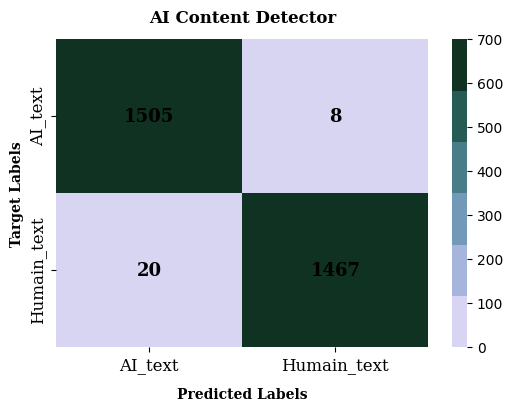

In [93]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)



# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.cubehelix_palette(start=2)
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=class_names, yticklabels=class_names,vmin=0,vmax=700,
                      annot_kws={"family": "Serif", 'color':'black','weight': 'bold', 'size': 13})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font2)
heatmap.set_ylabel('Target Labels', fontdict=font2)
heatmap.set_title('AI Content Detector', fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space


plt.show()